In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [2]:
from scipy.io import loadmat
import numpy as np
from pathlib import Path

dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [3]:
import sys
import os

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/TAN
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path


Vykresluji povrch terénu (může to chvíli trvat)...
...povrch vykreslen.


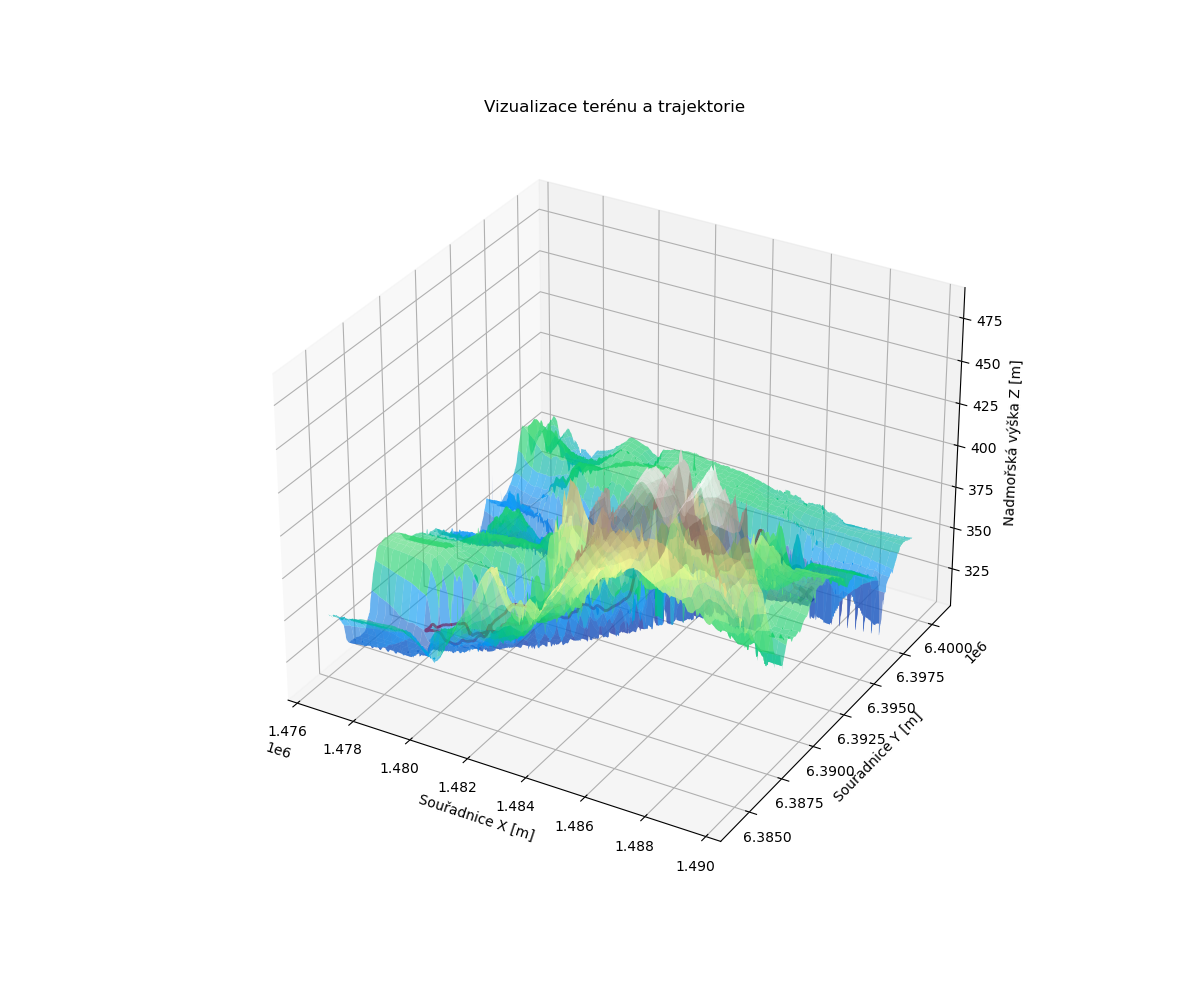

In [4]:
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters

%matplotlib widget

try:

    souradniceX_mapa = mat_data['souradniceX']
    souradniceY_mapa = mat_data['souradniceY']
    souradniceZ_mapa = mat_data['souradniceZ']
    
    souradniceGNSS = mat_data['souradniceGNSS'] 

except KeyError as e:
    print(f"Chyba: Proměnná {e} nebyla nalezena v .mat souboru.")
    exit()


x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie = souradniceGNSS[2, :]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


print("Vykresluji povrch terénu (může to chvíli trvat)...")
ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, 
                  cmap='terrain',      
                  alpha=0.6,          
                  label='Terén')
print("...povrch vykreslen.")


ax.plot(x_trajektorie, y_trajektorie, z_trajektorie, 
        'r-',             
        linewidth=2, 
        label='Trajektorie GNSS')


ax.plot([x_trajektorie[0]], [y_trajektorie[0]], [z_trajektorie[0]], 
        'go',             
        markersize=8, 
        label='Start')

ax.plot([x_trajektorie[-1]], [y_trajektorie[-1]], [z_trajektorie[-1]], 
        'kx',            
        markersize=10, 
        markeredgewidth=3,
        label='Cíl')



ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Vizualizace terénu a trajektorie')
ax.grid(True)

plt.show()

In [5]:
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 

# --- KROK 1: Extrakce 1D os z 2D mřížek ---
# Získáme unikátní souřadnice pro osy X a Y.
# Pro osu X vezmeme první řádek z X matice.
# Pro osu Y vezmeme první sloupec z Y matice.
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Rozměry 1D osy X: {x_axis_unique.shape}")
print(f"Rozměry 1D osy Y: {y_axis_unique.shape}")
print(f"Rozměry 2D dat výšek Z: {souradniceZ_mapa.shape}")


# --- KROK 2: Vytvoření interpolačního objektu ---
# POZOR: Scipy očekává, že osy budou v pořadí (y, x), protože
# NumPy pole jsou indexována jako (řádek, sloupec), což odpovídá (y, x).
print("\nVytvářím interpolační funkci...")
terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),  # N-tice 1D os (nejprve Y, pak X)
    souradniceZ_mapa,
    bounds_error=False,  # NEVYHAZUJ CHYBU
    fill_value=np.nan
)
print("...interpolační funkce vytvořena.")

# --- KROK 3: Vytvoření finální, uživatelsky přívětivé funkce ---
def terMap(px, py):
    """
    Vypočítá nadmořskou výšku pro dané souřadnice (px, py)
    pomocí interpolace z mapy terénu.
    
    Funkce zvládne jak jednotlivé body, tak celé pole bodů.
    """
    # Spojíme vstupní body do formátu, kterému interpolátor rozumí:
    # pole o dvou sloupcích [y, x].
    points_to_query = np.column_stack((py, px))
    
    # Zavoláme interpolátor a vrátíme výsledek
    return terMap_interpolator(points_to_query)

Rozměry 1D osy X: (2500,)
Rozměry 1D osy Y: (2500,)
Rozměry 2D dat výšek Z: (2500, 2500)

Vytvářím interpolační funkci...
...interpolační funkce vytvořena.



Očekávaná výška v bodě [1487547.1792843346, 6395520.41167761] je: 347.25 m


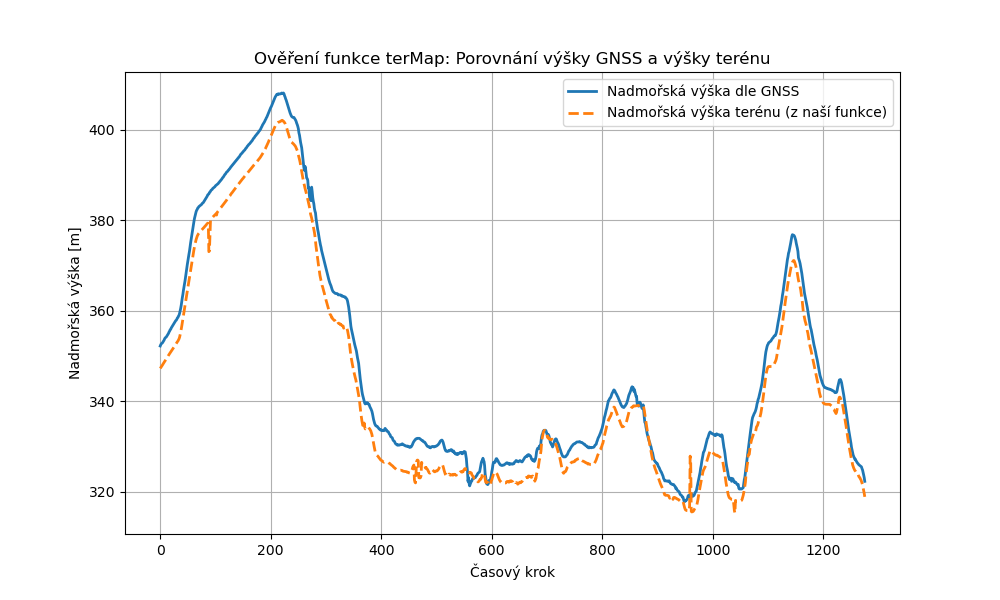

In [6]:
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]

test_x_valid = x_trajektorie[0]
test_y_valid = y_trajektorie[0]
vyska_v_bode = terMap(test_x_valid, test_y_valid)
print(f"\nOčekávaná výška v bodě [{test_x_valid}, {test_y_valid}] je: {vyska_v_bode[0]:.2f} m")

# Příklad 2: Získání výšky terénu pod celou GNSS trajektorií
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie_gnss = souradniceGNSS[2, :]

# Použijeme naši novou funkci k získání výšky terénu pod každým bodem trajektorie
z_terenu_pod_trajektorii = terMap(x_trajektorie, y_trajektorie)

# Ověření - vykreslení
plt.figure(figsize=(10, 6))
plt.plot(z_trajektorie_gnss, label='Nadmořská výška dle GNSS', linewidth=2)
plt.plot(z_terenu_pod_trajektorii, label='Nadmořská výška terénu (z naší funkce)', linestyle='--', linewidth=2)
plt.xlabel('Časový krok')
plt.ylabel('Nadmořská výška [m]')
plt.title('Ověření funkce terMap: Porovnání výšky GNSS a výšky terénu')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import torch
from math import pi

state_dim = 3
obs_dim = 1

F = torch.tensor([[1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.96925]])

Q = torch.diag(torch.tensor([36.0, 36.0, 0.05]))
R = torch.tensor([[3.0]])
delta_pos = np.diff(souradniceGNSS[:2, :], axis=1)
u_pos = np.pad(delta_pos, ((0, 0), (0, 1)), 'constant')
u_bias = np.zeros((1, u_pos.shape[1]))
# Spojíme a převedeme na tensor
u_sequence_cpu = torch.from_numpy(np.vstack((u_pos, u_bias))).float()

# ### ZDE JE KLÍČOVÁ OPRAVA ###
# Přesuneme sekvenci vstupů na stejné zařízení jako model
u_sequence = u_sequence_cpu.to(device)

print(f"Tenzor u_sequence je nyní na zařízení: {u_sequence.device}")

# Počáteční podmínky
x_0 = torch.tensor([souradniceGNSS[0, 0], souradniceGNSS[1, 0], 0.0])
P_0 = torch.tensor([[25.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0],
                    [0.0, 0.0, 10.0]])

# Nelineární funkce měření h(x)
def h_nl(x: torch.Tensor) -> torch.Tensor:
    # ... (vaše funkce h_nl je již v pořádku, protože používá x.device) ...
    px = x[:, 0]
    py = x[:, 1]
    b = x[:, 2]
    vyska_terenu_np = terMap(px.detach().cpu().numpy(), py.detach().cpu().numpy())
    vyska_terenu = torch.from_numpy(vyska_terenu_np).float().to(x.device)
    result = vyska_terenu + b
    result_safe = result.clone()
    result_safe[torch.isnan(result)] = 1e9
    return result_safe.unsqueeze(1)

print("Vytvářím instanci DynamicSystem...")
system_model = DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_nl,
    device=device  # Předáme definované zařízení
)
print("...objekt DynamicSystem byl úspěšně vytvořen.")
num_simulated_trajectories = 1
# ... zbytek vašeho kódu pro generování a zobrazení dat ...
# Nyní by měl proběhnout bez chyby, protože u_sequence je také na GPU.
x_generated, y_generated = utils.generate_data_with_input(
    system=system_model,
    num_trajectories=num_simulated_trajectories,
    u_sequence=u_sequence # Předáváme již přesunutý tenzor
)
# 3. Zobrazení výsledků
print(f"\nGenerování dat dokončeno.")
print(f"Rozměry vygenerovaných stavů 'x_generated': {x_generated.shape}")
print(f"Očekávaný tvar: [{num_simulated_trajectories}, {u_sequence.shape[1]}, {state_dim}]")
print(f"Rozměry vygenerovaných měření 'y_generated': {y_generated.shape}")
print(f"Očekávaný tvar: [{num_simulated_trajectories}, {u_sequence.shape[1]}, {obs_dim}]")

Tenzor u_sequence je nyní na zařízení: cuda:0
Vytvářím instanci DynamicSystem...
...objekt DynamicSystem byl úspěšně vytvořen.

Generování dat dokončeno.
Rozměry vygenerovaných stavů 'x_generated': torch.Size([1, 1276, 3])
Očekávaný tvar: [1, 1276, 3]
Rozměry vygenerovaných měření 'y_generated': torch.Size([1, 1276, 1])
Očekávaný tvar: [1, 1276, 1]


Vykresluji povrch terénu...
...povrch vykreslen.
Vykresluji 1 generovaných trajektorií...
...vykreslování dokončeno.


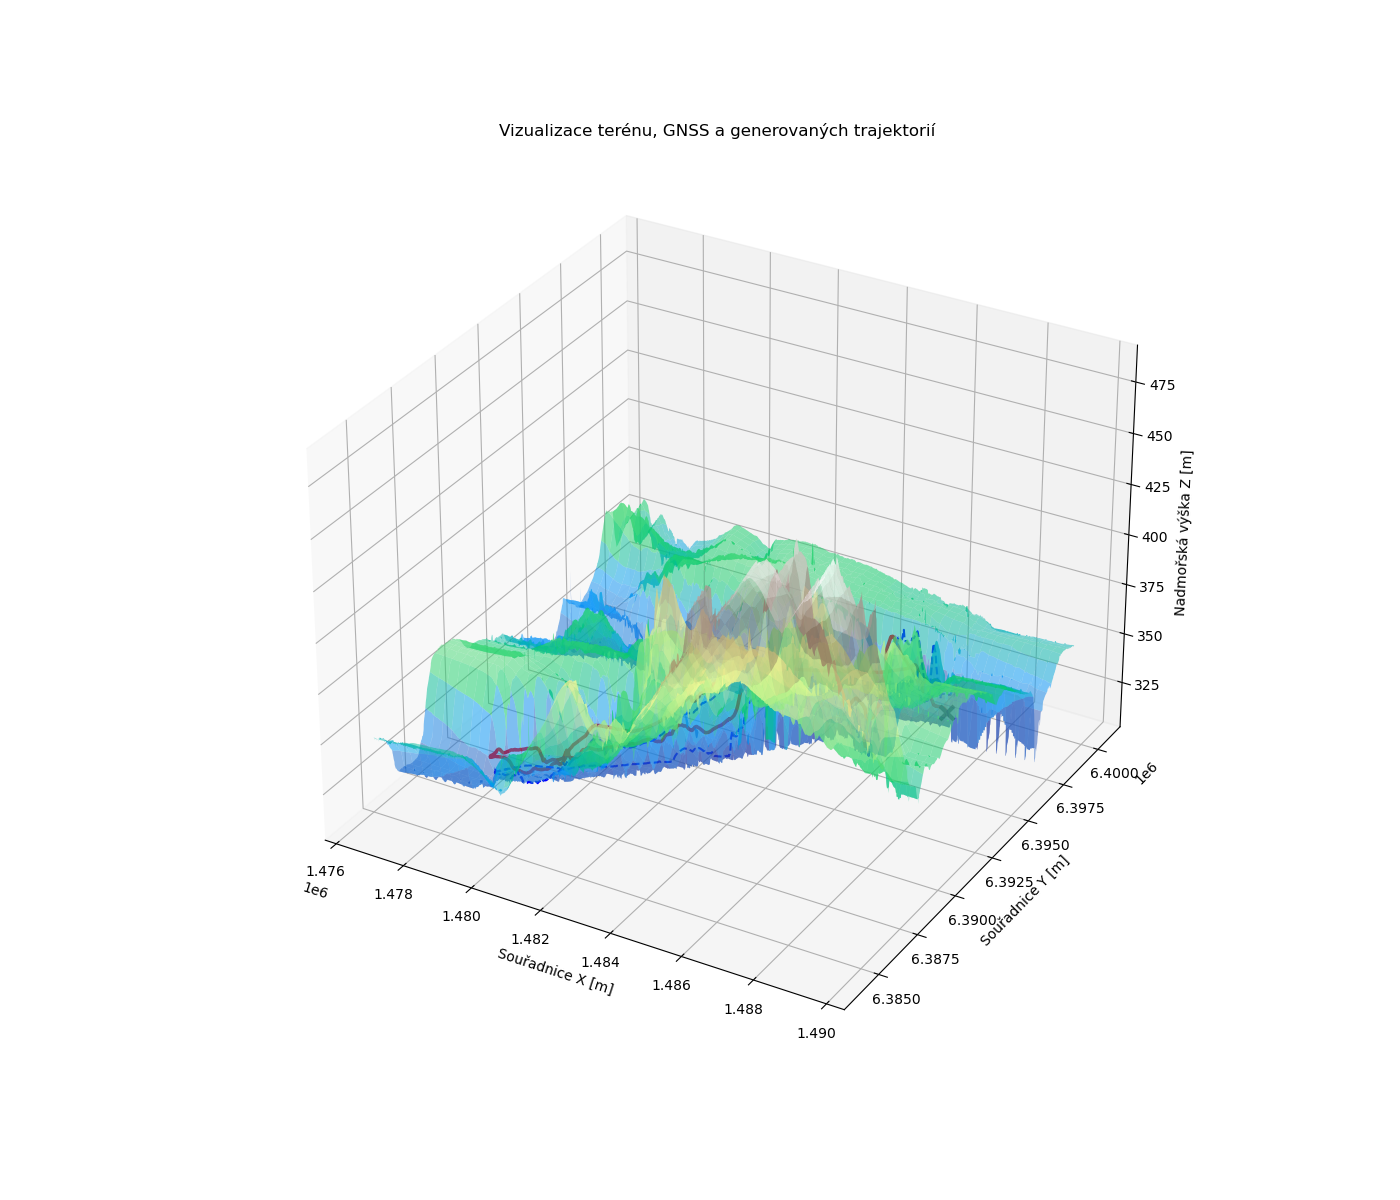

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Předpokládáme, že všechny proměnné z vašeho kódu již existují ---
# souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa
# souradniceGNSS
# x_generated (tensor o tvaru [5, 1276, 3])
# terMap (vaše interpolační funkce)

# --- Krok 1: Převod vygenerovaných dat z PyTorch tenzoru na NumPy pole ---
# .cpu() je pojistka pro případ, že by data byla na GPU
x_gen_np = x_generated.cpu().numpy()

# --- Krok 2: Vytvoření základního grafu (váš kód) ---
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

print("Vykresluji povrch terénu...")
ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, 
                  cmap='terrain',      
                  alpha=0.5, # Mírně průhlednější, aby byly vidět trajektorie
                  label='Terén')
print("...povrch vykreslen.")

# Vykreslení původní "pravdivé" GNSS trajektorie pro srovnání
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie = souradniceGNSS[2, :]

ax.plot(x_trajektorie, y_trajektorie, z_trajektorie, 
        'r-',             
        linewidth=2.5, # Trochu tlustší, aby byla vidět
        label='Původní trajektorie (GNSS)')

# --- Krok 3: Vykreslení všech 5 vygenerovaných trajektorií ---
print(f"Vykresluji {num_simulated_trajectories} generovaných trajektorií...")

for i in range(num_simulated_trajectories):
    # Extrakce X a Y souřadnic pro i-tou trajektorii
    px_generated = x_gen_np[i, :, 0]
    py_generated = x_gen_np[i, :, 1]
    
    # !!! DŮLEŽITÉ: Výpočet Z souřadnice (nadmořské výšky) pomocí mapy !!!
    pz_generated = terMap(px_generated, py_generated)
    
    # Vykreslíme trajektorii. Label přidáme jen k první, aby nebyla legenda přeplněná.
    label_text = 'Generované trajektorie' if i == 0 else None
    
    ax.plot(px_generated, py_generated, pz_generated, 
            'b--', # Modrá přerušovaná čára
            linewidth=1.5, 
            label=label_text)

print("...vykreslování dokončeno.")
    
# --- Krok 4: Finalizace grafu (váš kód) ---
ax.plot([x_trajektorie[0]], [y_trajektorie[0]], [z_trajektorie[0]], 
        'go', markersize=8, label='Start (GNSS)')

ax.plot([x_trajektorie[-1]], [y_trajektorie[-1]], [z_trajektorie[-1]], 
        'kx', markersize=10, markeredgewidth=3, label='Cíl (GNSS)')

ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Vizualizace terénu, GNSS a generovaných trajektorií')
ax.grid(True)
plt.show()

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# TODO PARTICLE FILTER NEPODPORUJE VSTUP AKTUALNE - UPRAVIT

# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 200 # Změňte zpět na 100 nebo kolik potřebujete
NUM_TEST_TRAJ = 5

# ==============================================================================
# 2. PŘÍPRAVA DAT (OPRAVENO)
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")

# ### ZDE JE KLÍČOVÁ OPRAVA ###
# Ořízneme u_sequence PŘED generováním dat.
u_sequence_test = u_sequence[:, :TEST_SEQ_LEN]

# Nyní předáme oříznutou sekvenci 'u', takže i 'x' a 'y' budou mít správnou délku.
x_test, y_test = utils.generate_data_with_input(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ, 
    u_sequence=u_sequence_test
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

print("y shape:", y_test.shape) # Mělo by být [1, 20, 1]
print("u shape:", u_sequence_test.shape) # Mělo by být [3, 20]
print("x shape:", x_test.shape) # Mělo by být [1, 20, 3]

# ==============================================================================
# 3. INICIALIZACE FILTRŮ
# ==============================================================================
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=100000)

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA (OPRAVENO)
# ==============================================================================
all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        
        # ### ZDE JE KLÍČOVÁ OPRAVA ###
        # Použijeme stejnou, již oříznutou a připravenou u_sequence_test
        u_seq_gpu = u_sequence_test.to(device)

        # Nyní mají y_seq a u_sequence shodnou délku
        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu, 
            u_sequence=u_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu,u_sequence=u_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_ukf_ideal, anees_ukf_ideal = [], []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat, P_hat):
            # Délka pravdivé trajektorie
            true_len = x_true.shape[0]
            
            # Ořízneme odhady, aby měly stejnou délku jako pravdivá data.
            # Bereme prvních `true_len` prvků (tj. pro t=0 až t=299).
            x_hat_aligned = x_hat[:true_len]
            P_hat_aligned = P_hat[:true_len]
            
            # Nyní mají všechny tenzory shodnou délku
            mse = F.mse_loss(x_hat_aligned, x_true).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat_aligned.unsqueeze(0), P_hat_aligned.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
# print(f"{'PF (Nepřesný model)':<35} | {avg(mse_pf_mis):<20.4f} | {avg(anees_pf_mis):<20.4f}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
# print(f"{'PF (Ideální model)':<35} | {avg(mse_pf_ideal):<20.4f} | {avg(anees_pf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)


Generuji 5 testovacích trajektorií o délce 200...
Generování dat dokončeno.
y shape: torch.Size([5, 200, 1])
u shape: torch.Size([3, 200])
x shape: torch.Size([5, 200, 3])

Vyhodnocuji modely na 5 testovacích trajektoriích...
200
torch.Size([3, 200])
PF-SIR (ideální model) dokončen pro trajektorii 1/5.
Dokončena trajektorie 1/5...
200
torch.Size([3, 200])
PF-SIR (ideální model) dokončen pro trajektorii 2/5.
Dokončena trajektorie 2/5...
200
torch.Size([3, 200])
PF-SIR (ideální model) dokončen pro trajektorii 3/5.
Dokončena trajektorie 3/5...
200
torch.Size([3, 200])
PF-SIR (ideální model) dokončen pro trajektorii 4/5.
Dokončena trajektorie 4/5...
200
torch.Size([3, 200])
PF-SIR (ideální model) dokončen pro trajektorii 5/5.
Dokončena trajektorie 5/5...

Počítám finální metriky pro jednotlivé trajektorie...

FINÁLNÍ VÝSLEDKY (průměr přes 5 běhů)
Model                               | Průměrné MSE         | Průměrný ANEES      
--------------------------------------------------------------

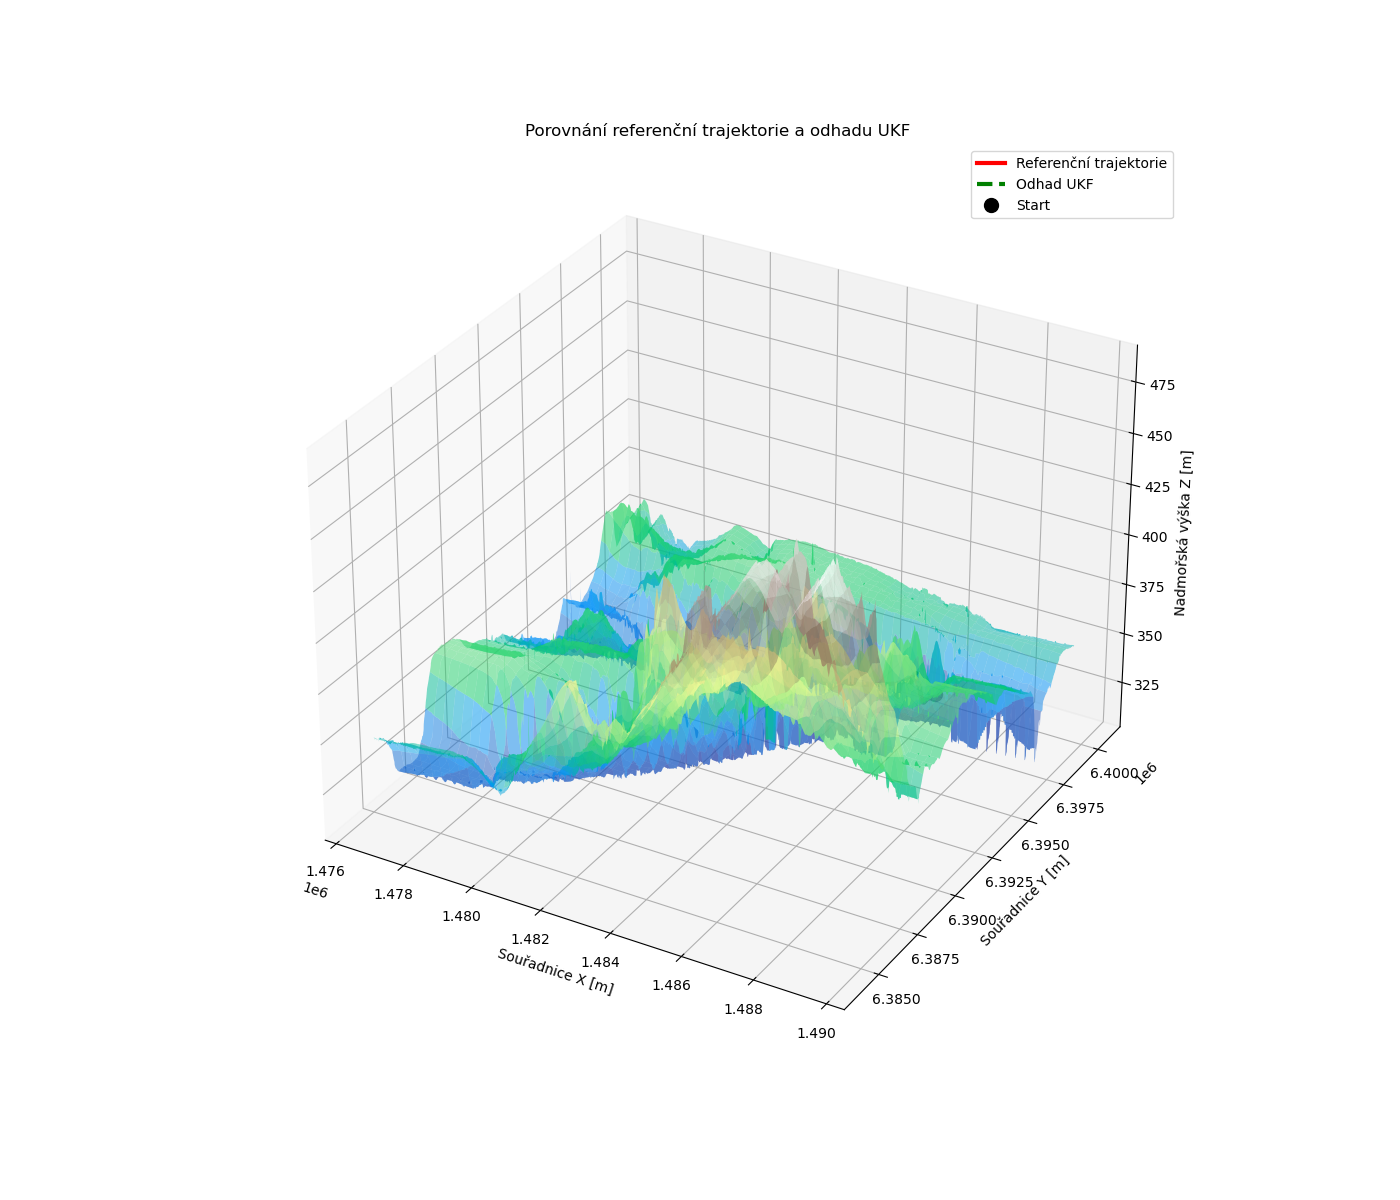

In [10]:
import matplotlib.pyplot as plt
import numpy as np
x_true_plot = all_x_true_cpu[0].numpy()
x_ukf_plot = all_x_hat_ukf_ideal_cpu[0].numpy()

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, cmap='terrain', alpha=0.5)

px_true = x_true_plot[:, 0]
py_true = x_true_plot[:, 1]
pz_true = terMap(px_true, py_true)
ax.plot(px_true, py_true, pz_true, 'r-', linewidth=3, label='Referenční trajektorie')

px_ukf = x_ukf_plot[:, 0]
py_ukf = x_ukf_plot[:, 1]
pz_ukf = terMap(px_ukf, py_ukf)
ax.plot(px_ukf, py_ukf, pz_ukf, 'g--', linewidth=3, label='Odhad UKF')

ax.plot([px_true[0]], [py_true[0]], [pz_true[0]], 
        'o', color='black', markersize=10, label='Start')

ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Porovnání referenční trajektorie a odhadu UKF')
ax.legend()
ax.grid(True)
plt.show()

# 4D model


In [ ]:
import torch
from math import pi

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
initial_velocity = torch.from_numpy(initial_velocity_np)

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])

# Nelineární funkce měření h(x)
def h(x: torch.Tensor) -> torch.Tensor:
    eps = 1e-12
    # _w reprezentuje world frame
    px_w = x[:, 0]
    py_w = x[:, 1]
    vx_w = x[:, 2]
    vy_w = x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2+vy_w**2)
    vx_b = vx_w**2/(norm_v_w+eps)-vy_w**2/(norm_v_w+eps)
    vy_b = (vy_w*vx_w)/(norm_v_w+eps) + (vx_w*vy_w)/(norm_v_w+eps)
    vyska_terenu_np = terMap(px_w.detach().cpu().numpy(), py_w.detach().cpu().numpy())
    vyska_terenu = torch.from_numpy(vyska_terenu_np).float().to(x.device)
    vyska_terenu[torch.isnan(vyska_terenu)] = 1e9 # Nahradíme NaN velkým číslem

    # Spojíme tři vektory (každý o délce N) do matice [N, 3]
    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)
    
    return result

print("Vytvářím instanci DynamicSystem...")
system_model = DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h,
    device=device  # Předáme definované zařízení
)